#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [1]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from pymorphy2 import MorphAnalyzer
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
morph = MorphAnalyzer()

### 1. Подготовка данных

In [2]:
wiki = open('wiki_data.txt', encoding='utf-8').read().split('\n')
print('Общее количество текстов в датасете:', len(wiki))
print('Пример текста:')
print(wiki[100])

Общее количество текстов в датасете: 20003
Пример текста:
######Папуа — Новая Гвинея на летних Олимпийских играх 1976############Папуа — Новая Гвинея принимала участие в Летних Олимпийских играх 1976 года в Монреале (Канада) в первый раз за свою историю, но не завоевала ни одной медали. Страну представляли 6 спортсменов, принимавших участие в соревнованиях по боксу, лёгкой атлетике и стрельбе.######################################################


Напишем функцию для предобработки данных с лемматизацией через pymorphy2.

In [3]:
def preprocess(text):
    tokenized = re.findall('[А-Яа-яёЁA-Za-z0-9-]+', text.lower())
    lemmatized = [morph.parse(token)[0].normal_form for token in tokenized]
    return lemmatized

print('Пример разбора:')
print(preprocess(wiki[100]))

Пример разбора:
['папуа', 'новый', 'гвинея', 'на', 'летний', 'олимпийский', 'игра', '1976', 'папуа', 'новый', 'гвинея', 'принимать', 'участие', 'в', 'летний', 'олимпийский', 'игра', '1976', 'год', 'в', 'монреаль', 'канада', 'в', 'первый', 'раз', 'за', 'свой', 'история', 'но', 'не', 'завоевать', 'ни', 'один', 'медаль', 'страна', 'представлять', '6', 'спортсмен', 'принимать', 'участие', 'в', 'соревнование', 'по', 'бокс', 'лёгкий', 'атлетика', 'и', 'стрельба']


Проводим предобработку текстов в датасете, подсчитываем количество вхождений слов в корпус.

In [4]:
data = []
vocab = Counter()

for text in wiki:
    preprocessed = preprocess(text)
    data.append(preprocessed)
    vocab.update(preprocessed)

print('Количество уникальных слов в корпусе:', len(vocab))

Количество уникальных слов в корпусе: 204978


Так как слов достаточно много, отфильтруем те, которые встретились больше 15 раз.

In [5]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 15:
        filtered_vocab.add(word)

print('Размер отфильтрованного словаря:', len(filtered_vocab))

Размер отфильтрованного словаря: 20819


Создадим словари word2id и id2word с индексами слов и заменим слова в текстах на индексы.

In [6]:
word2id = {'PAD': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [7]:
id2word = {i: word for word, i in word2id.items()}

In [8]:
sentences = []

for text in data:
    sentences.append([word2id[token] for token in text if token in word2id])

### 2. Модель skip-gram

Возьмем функцию генерации обучающих примеров для skip-gram (с семинара) и заменим в ней принцип генерации отрицательных примеров так, чтобы учитывалась частотность слов. Для этого воспользуемся np.random.choice() с добавлением параметра p, куда поместим вероятности для каждого слова (так как необходимо генерировать слова обратно пропорционально их частотности, вероятности необходимо преобразовать).  

In [9]:
sentences_bow = [id for text in sentences for id in text]
probs = Counter(sentences_bow)
probs = {id: prob/len(sentences_bow) for id, prob in probs.items()}
inverse_probs = {id: (1-prob) for id, prob in probs.items()}
inverse_probs = {id: prob/sum(inverse_probs.values()) for id, prob in inverse_probs.items()}

In [10]:
vocab_size = len(id2word)

In [11]:
def gen_batches_sg(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []
        
        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.choice(list(inverse_probs.keys()), p=list(inverse_probs.values())))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

Задаем модель и в обучении устанавливаем размер окна 12 (так как в gen_batches window -- это количество слов слева/справа, а не их сумма, параметр window должен быть 6).

In [12]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
model.fit(gen_batches_sg(sentences[:19000], window=6),
          validation_data=gen_batches_sg(sentences[19000:],  window=6),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
2000/2000 [==============================] - 2635s 1s/step - loss: 0.4995 - accuracy: 0.7621 - val_loss: 0.5078 - val_accuracy: 0.7567
Epoch 2/2
2000/2000 [==============================] - 2655s 1s/step - loss: 0.4228 - accuracy: 0.8120 - val_loss: 0.4740 - val_accuracy: 0.8036


In [14]:
embeddings_sg = model.layers[2].get_weights()[0]

### 3. Модель CBOW

Возьмем функцию генерации обучающих примеров для CBOW (с семинара) и аналогично функции для skip-gram заменим в ней принцип генерации отрицательных примеров с помощью параметра p в np.random.choice().

In [15]:
def gen_batches_cbow(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.choice(list(inverse_probs.keys()), p=list(inverse_probs.values())))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

Задаем модель и при обучении устанавливаем окно 6 (то есть параметр window в get_batches = 3).

In [16]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(6,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.fit(gen_batches_cbow(sentences[:19000], window=3),
          validation_data=gen_batches_cbow(sentences[19000:],  window=3),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
2000/2000 [==============================] - 2816s 1s/step - loss: 0.4055 - accuracy: 0.8243 - val_loss: 0.3631 - val_accuracy: 0.8500
Epoch 2/2
2000/2000 [==============================] - 2639s 1s/step - loss: 0.3349 - accuracy: 0.8627 - val_loss: 0.3086 - val_accuracy: 0.8771


In [18]:
embeddings_cbow = model.layers[2].get_weights()[0]

### 4. Результаты

Функция для нахождения ближайших слов (с семинара):

In [19]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

Посмотрим на несколько примеров.

In [78]:
for word in ['мнение', 'год', 'лететь', 'город']:
    print('-'*30)
    print('Ближайшие для слова:', word)
    print('-'*30)
    print('SKIP-GRAM')
    for word in most_similar(word, embeddings_sg):
        print(word)
    print('\nCBOW')
    for word in most_similar(word, embeddings_cbow):
        print(word)

------------------------------
Ближайшие для слова: мнение
------------------------------
SKIP-GRAM
мнение
колония
следование
атлетика
магаданский
фрг
вологодский
самозанятой
радовицкий
опг

CBOW
опг
уиттс
сумбат
s-выражение
кучеряновский
мыза
минцлов
озерецковский
аланский
алнашский
------------------------------
Ближайшие для слова: год
------------------------------
SKIP-GRAM
год
январь
май
июнь
декабрь
в
окончить
март
г
сентябрь

CBOW
сентябрь
декабрь
январь
июль
ноябрь
октябрь
февраль
апрель
май
март
------------------------------
Ближайшие для слова: лететь
------------------------------
SKIP-GRAM
лететь
контролировать
гармония
йонг
тыс
румынский
эркетинский
оккупировать
древесина
венгр

CBOW
венгр
сейшелы
results
юнли
гибралтар
веспасиано
буянов
теплопаровоз
гиббонс
флегонт
------------------------------
Ближайшие для слова: город
------------------------------
SKIP-GRAM
город
уездный
шевченковский
чел
волость
1-й
центр
садовый
исток
данные

CBOW
данные
мера
мнение
принцип
специ

Примеры кажутся не очень удачными для обеих моделей: видно, что для более абстрактных понятий и CBOW, и skip-gram плохо находят близкие по смыслу слова. Возможно, причина в недообучении, т.к. количество итераций в эпохе было уменьшено до 2000 (по сравнению с семинаром), чтобы уменьшить время обучения.

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [21]:
import gensim

Обучим word2vec модель c такими параметрами: 
- размер вектора равен 200,
- минимальная частота слова в корпусе равна 15 (как и в первом задании),
- максимальный размер словаря равен 15000,
- размер окна равен 8 (в gensim window -- это расстояние между текущим и предсказываемым словом, поэтому оно должно быть равно 4),
- количество итераций равно 5,
- алгоритм CBOW (sg=0),
- оптимизация -- негативное сэмплирование с 6 примерами,
- downsampling частотных слов -- 1e-4,
- downsampling частотных слов в negative sampling -- 0.8,
- агрегация в cbow -- среднее (cbow_mean=1).

In [22]:
w2v = gensim.models.Word2Vec(data, 
                             vector_size=200, 
                             min_count=15, 
                             max_vocab_size=15000,
                             window=4,
                             epochs=5,
                             sg=0,
                             hs=0,
                             negative=6,
                             sample=1e-4,
                             ns_exponent=0.8,
                             cbow_mean=1)

In [79]:
w2v.wv.most_similar('город')

[('столица', 0.7721713781356812),
 ('пригород', 0.7401325106620789),
 ('окраина', 0.6915684342384338),
 ('городок', 0.6827177405357361),
 ('соседний', 0.662598729133606),
 ('близ', 0.6558278799057007),
 ('квартал', 0.6504666805267334),
 ('аксай', 0.6503130793571472),
 ('окрестность', 0.6450324654579163),
 ('центр', 0.6370261907577515)]

In [81]:
w2v.wv.most_similar('мнение')

[('повод', 0.7529137134552002),
 ('отмечать', 0.7385819554328918),
 ('полагать', 0.7367995977401733),
 ('высказывание', 0.7124258875846863),
 ('утверждать', 0.7044962644577026),
 ('мысль', 0.6983209848403931),
 ('сми', 0.692546546459198),
 ('сас', 0.6916524171829224),
 ('утверждение', 0.6904582381248474),
 ('историк', 0.6888084411621094)]

Обучим fasttext модель с такими параметрами:
- размер вектора 200 (как и для word2vec),
- минимальная длина для символьных нграмм равна 4,
- максимальная длина для символьных нграмм равна 7.

In [24]:
ft = gensim.models.FastText(data,
                            vector_size=200,
                            min_n=4,
                            max_n=7)

In [80]:
ft.wv.most_similar('город')

[('ужгород', 0.9779555797576904),
 ('городец', 0.9621424674987793),
 ('горо', 0.9580899477005005),
 ('звенигород', 0.9542044401168823),
 ('белгород', 0.9530250430107117),
 ('огород', 0.9507831335067749),
 ('город-сад', 0.9491571187973022),
 ('городня', 0.944377064704895),
 ('городов', 0.9388973116874695),
 ('городок', 0.9388024806976318)]

In [82]:
ft.wv.most_similar('мнение')

[('сомнение', 0.9561328887939453),
 ('объяснение', 0.8876162767410278),
 ('затемнение', 0.8808321356773376),
 ('утверждение', 0.8778405785560608),
 ('извинение', 0.8772552609443665),
 ('причинение', 0.8754624128341675),
 ('выяснение', 0.8708090782165527),
 ('обвинение', 0.8607289791107178),
 ('осквернение', 0.8601470589637756),
 ('тиснение', 0.8540854454040527)]

Заметно, что fasttext подбирает похожие слова по совпадающим н-граммам, но варианты word2vec все равно кажутся более подходящими. Обе модели, тем не менее, более удачны, чем модели из первого задания.

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

### Подготовка данных

Для начала предобработаем датасет с помощью функции preprocess() из первого задания.

In [26]:
labeled = pd.read_csv('labeled.csv')
print(labeled.shape)

(14412, 2)


In [27]:
labeled['preprocessed'] = labeled.comment.apply(preprocess)

In [28]:
labeled.sample(5)

,comment,toxic,preprocessed
13235,Хм... Логично.Тогда давай лучше будем загадыва...,0.0,"[хм, логично, тогда, давать, хороший, быть, за..."
12024,"Насчет доли Китая сомневаюсь. Что у нас, что С...",0.0,"[насчёт, доля, китай, сомневаться, что, у, мы,..."
10187,"Сложил ингридиенты, получил 1.5 кг. Не великов...",0.0,"[сложить, ингридиент, получить, 1, 5, кг, не, ..."
7124,То есть накал растет все сильней и сильней. на...,0.0,"[то, есть, накал, расти, всё, сильный, и, силь..."
13503,"Культ карго, не понимают как работает, но моля...",0.0,"[культ, карго, не, понимать, как, работать, но..."


Теперь составим словарь уникальных слов (объем кажется оптимальным, поэтому фильтровать не будем, чтобы учесть при классификации все слова в обучающей выборке).

In [29]:
vocab_clf = Counter()

for text in labeled.preprocessed:
    vocab_clf.update(text)

print('Объем словаря:', len(vocab_clf))

Объем словаря: 36589


In [34]:
word2id_clf = {'PAD': 0}

for word in vocab_clf:
    word2id_clf[word] = len(word2id_clf)
    
id2word_clf = {i: word for word, i in word2id_clf.items()}

Переводим слова в индексы, делим датасет на обучающую и валидационную выборки.

In [35]:
X = []
for tokens in labeled.preprocessed:
    ids = [word2id_clf[token] for token in tokens if token in word2id_clf]
    X.append(ids)

In [36]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = labeled.toxic.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

### Эмбеддинги skip-gram (из 1 задания)

Построим классификатор на эмбеддингах skip-gram из первого задания (embeddings_sg).

In [39]:
weights_sg = np.zeros((len(word2id_clf), 300))

for word, i in word2id_clf.items():

    if word == 'PAD':
        continue

    try:
        weights_sg[i] = embeddings_sg[word2id[word]]
    
    except KeyError:
        continue
        weights_sg[i] = embeddings_sg[word2id['опрагпллирао']]

In [40]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_clf), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_sg])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6303 - accuracy: 0.6658 - val_loss: 0.6433 - val_accuracy: 0.6442
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.6675 - val_loss: 0.6471 - val_accuracy: 0.6442
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6063 - accuracy: 0.6675 - val_loss: 0.6471 - val_accuracy: 0.6442
Epoch 4/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6059 - accuracy: 0.6675 - val_loss: 0.6472 - val_accuracy: 0.6442
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6054 - accuracy: 0.6675 - val_loss: 0.6468 - val_accuracy: 0.6442
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6051 - accuracy: 0.6675 - val_loss: 0.6478 - val_accuracy: 0.6442
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6047 - accuracy: 0.6675 - val_loss: 0.6480 - val_accuracy: 0.6442
Epoch 

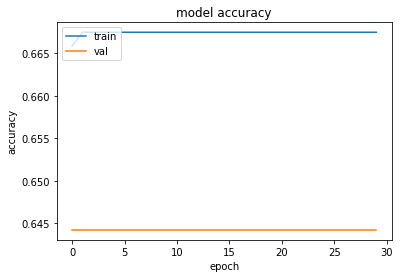

In [42]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Очевидно, что классификация на эмбеддинговой модели skip-gram из первого задания показывает плохие результаты: модель не обучается. Могло также повлиять и то, что эмбеддинги обучались на материалах Википедии, а классификацию мы строим на другом датасете с очень специфичной лексикой.

### Эмбеддинги CBOW (из 1 задания)

Теперь построим классификатор на эмбеддингах CBOW из первого задания (embeddings_cbow).

In [43]:
weights_cbow = np.zeros((len(word2id_clf), 300))

for word, i in word2id_clf.items():

    if word == 'PAD':
        continue

    try:
        weights_cbow[i] = embeddings_cbow[word2id[word]]
    
    except KeyError:
        continue
        weights_cbow[i] = embeddings_cbow[word2id['опрагпллирао']]

In [44]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_clf), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_cbow])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6246 - accuracy: 0.6666 - val_loss: 0.6493 - val_accuracy: 0.6442
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6097 - accuracy: 0.6672 - val_loss: 0.6483 - val_accuracy: 0.6442
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6076 - accuracy: 0.6672 - val_loss: 0.6445 - val_accuracy: 0.6442
Epoch 4/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6053 - accuracy: 0.6672 - val_loss: 0.6446 - val_accuracy: 0.6442
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6033 - accuracy: 0.6672 - val_loss: 0.6396 - val_accuracy: 0.6442
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6012 - accuracy: 0.6673 - val_loss: 0.6395 - val_accuracy: 0.6442
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5992 - accuracy: 0.6672 - val_loss: 0.6376 - val_accuracy: 0.6442
Epoch 

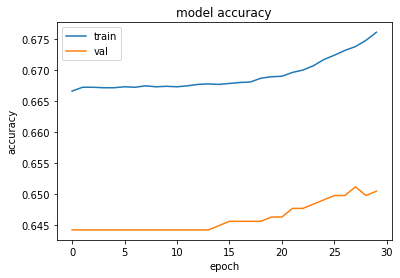

In [46]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Здесь уже результаты получше, чем у первой модели (на последней итерации метрика accuracy достигает 0.65), но эффективность обучения с такими эмбеддингами все равно низкая.

### Эмбеддинги word2vec (gensim, из 2 задания)

Построим классификатор на эмбеддингах word2vec, обученных через gensim во втором задании (w2v).

In [47]:
weights_w2v = np.zeros((len(word2id_clf), 200))

for word, i in word2id_clf.items():

    if word == 'PAD':
        continue

    try:
        weights_w2v[i] = w2v.wv[word]
    
    except KeyError:
        continue
        weights_w2v[i] = w2v.wv['опрагпллирао']

In [48]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_clf), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_w2v])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6276 - accuracy: 0.6604 - val_loss: 0.6307 - val_accuracy: 0.6442
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5918 - accuracy: 0.6675 - val_loss: 0.6144 - val_accuracy: 0.6442
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5759 - accuracy: 0.6676 - val_loss: 0.5998 - val_accuracy: 0.6463
Epoch 4/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5641 - accuracy: 0.6703 - val_loss: 0.5901 - val_accuracy: 0.6540
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5548 - accuracy: 0.6772 - val_loss: 0.5835 - val_accuracy: 0.6574
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5475 - accuracy: 0.6863 - val_loss: 0.5752 - val_accuracy: 0.6699
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5413 - accuracy: 0.6941 - val_loss: 0.5689 - val_accuracy: 0.6845
Epoch 

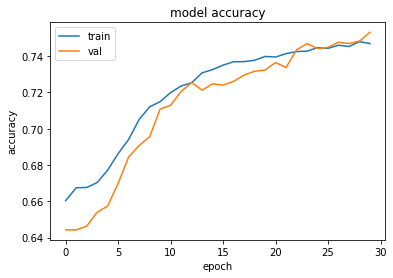

In [50]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Результаты лучше, чем у первых двух моделей: метрика accuracy на валидационной выборке достигает 0.75. Видно, что с каждой эпохой растет эффективность обучения.

### Эмбеддинги fasttext (gensim, из 2 задания)

Построим классификатор на эмбеддингах fasttext, обученных через gensim во втором задании (ft).

In [51]:
weights_ft = np.zeros((len(word2id_clf), 200))

for word, i in word2id_clf.items():

    if word == 'PAD':
        continue

    try:
        weights_ft[i] = ft.wv[word]
    
    except KeyError:
        continue
        weights_ft[i] = ft.wv['опрагпллирао']

In [52]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_clf), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_ft])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [53]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6030 - accuracy: 0.6672 - val_loss: 0.6195 - val_accuracy: 0.6567
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5775 - accuracy: 0.6815 - val_loss: 0.6028 - val_accuracy: 0.6727
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5661 - accuracy: 0.6884 - val_loss: 0.5950 - val_accuracy: 0.6803
Epoch 4/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5581 - accuracy: 0.6965 - val_loss: 0.5862 - val_accuracy: 0.6893
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5521 - accuracy: 0.7035 - val_loss: 0.5816 - val_accuracy: 0.6976
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5471 - accuracy: 0.7057 - val_loss: 0.5758 - val_accuracy: 0.6997
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5428 - accuracy: 0.7128 - val_loss: 0.5684 - val_accuracy: 0.7094
Epoch 

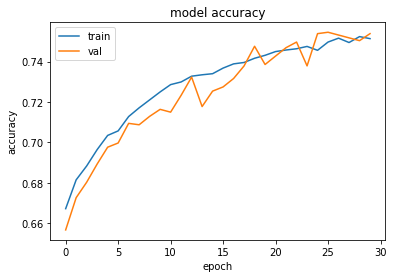

In [54]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Результат очень похож на результат предыдущей модели, accuracy также около 0.75, однако на валидационной выборке метрика более нестабильна, чем у модели word2vec.

### Предобученная модель

Построим классификатор на предобученных эмбеддингах, для этого скачаем модель [ruwikiruscorpora_upos_cbow_300_10_2021](https://rusvectores.org/ru/models/) с rusvectores.

Так как токены в модели содержат частеречную разметку (в формате UD), необходимо будет провести соответствующую предобработку датасета через UDPipe.

In [55]:
import ufal.udpipe
from conllu import parse

Берем готовый код для морфологического разбора предложений с помощью UDPipe.

In [56]:
# from: UDPipe <http://github.com/ufal/udpipe/>

class Model:
    def __init__(self, path):
        """Load given model."""
        self.model = ufal.udpipe.Model.load(path)
        if not self.model:
            raise Exception("Cannot load UDPipe model from file '%s'" % path)

    def tokenize(self, text):
        """Tokenize the text and return list of ufal.udpipe.Sentence-s."""
        tokenizer = self.model.newTokenizer(self.model.DEFAULT)
        if not tokenizer:
            raise Exception("The model does not have a tokenizer")
        return self._read(text, tokenizer)

    def read(self, text, in_format):
        """Load text in the given format (conllu|horizontal|vertical) and return list of ufal.udpipe.Sentence-s."""
        input_format = ufal.udpipe.InputFormat.newInputFormat(in_format)
        if not input_format:
            raise Exception("Cannot create input format '%s'" % in_format)
        return self._read(text, input_format)

    def _read(self, text, input_format):
        input_format.setText(text)
        error = ufal.udpipe.ProcessingError()
        sentences = []

        sentence = ufal.udpipe.Sentence()
        while input_format.nextSentence(sentence, error):
            sentences.append(sentence)
            sentence = ufal.udpipe.Sentence()
        if error.occurred():
            raise Exception(error.message)

        return sentences

    def tag(self, sentence):
        """Tag the given ufal.udpipe.Sentence (inplace)."""
        self.model.tag(sentence, self.model.DEFAULT)

    def parse(self, sentence):
        """Parse the given ufal.udpipe.Sentence (inplace)."""
        self.model.parse(sentence, self.model.DEFAULT)

    def write(self, sentences, out_format):
        """Write given ufal.udpipe.Sentence-s in the required format (conllu|horizontal|vertical)."""

        output_format = ufal.udpipe.OutputFormat.newOutputFormat(out_format)
        output = ''
        for sentence in sentences:
            output += output_format.writeSentence(sentence)
        output += output_format.finishDocument()

        return output

Загружаем заранее скачанную [отсюда](https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-3131) модель UDPipe для русского языка (обученную на СинТагРусе) и создаем функцию предобработки текста с помощью модели.

In [57]:
udpipe_model = Model('russian-syntagrus-ud-2.5-191206.udpipe')

In [58]:
def preprocess_udpipe(text):

    sentences_tokenized = udpipe_model.tokenize(text)
    for sent in sentences_tokenized:
        udpipe_model.tag(sent)
        udpipe_model.parse(sent)
    sentences_parsed = udpipe_model.write(sentences_tokenized, 'conllu')

    text_tokenized = []

    for sent in parse(sentences_parsed):
            for token in sent:
                if token['upos'] != 'PUNCT':
                    text_tokenized.append(token['lemma'].lower()+'_'+token['upos'])

    return text_tokenized

Проводим предобработку текстов в датасете, создаем словари с индексами слов (словарь фильтровать не будем), делим датасет на обучающую и тестовую выборки.

In [59]:
labeled['preprocessed_udpipe'] = labeled.comment.apply(preprocess_udpipe)

In [83]:
labeled.sample(5)

,comment,toxic,preprocessed,preprocessed_udpipe
12417,А как же предупредить за 2 недели?\n,0.0,"[а, как, же, предупредить, за, 2, неделя]","[а_CCONJ, как_ADV, же_PART, предупредить_VERB,..."
5710,Какое точное описание. Педофил-порашник 29лвл\n,1.0,"[какой, точный, описание, педофил-порашник, 29...","[какой_DET, точный_ADJ, описание_NOUN, педофит..."
4991,Я не говорила ничего о чрезмерной нагрузке. За...,0.0,"[я, не, говорить, ничего, о, чрезмерный, нагру...","[я_PRON, не_PART, говорить_VERB, ничто_PRON, о..."
1219,"Как говорится на стороне одного законы, на сто...",0.0,"[как, говориться, на, сторона, один, закон, на...","[как_SCONJ, говорить_VERB, на_ADP, сторона_NOU..."
8402,"Один из кадров - да, главная достопримечательн...",0.0,"[один, из, кадр, -, да, главный, достопримечат...","[один_NUM, из_ADP, кадр_NOUN, да_PART, главный..."


In [61]:
vocab_ud = Counter()

for text in labeled.preprocessed_udpipe:
    vocab_ud.update(text)

print('Объем словаря:', len(vocab_ud))

Объем словаря: 44096


In [62]:
word2id_ud = {'PAD': 0}

for word in vocab_ud:
    word2id_ud[word] = len(word2id_ud)
    
id2word_ud = {i: word for word, i in word2id_ud.items()}

In [63]:
X = []

for tokens in labeled.preprocessed_udpipe:
    ids = [word2id_ud[token] for token in tokens if token in word2id_ud]
    X.append(ids)

In [64]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = labeled.toxic.values

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

Загружаем заранее скачанную с rusvectores модель, передаем матрицу с векторами в слой эмбеддингов и обучаем классификатор.

In [66]:
pretrained_model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [67]:
weights_pretrained = np.zeros((len(word2id_ud), 300))

for word, i in word2id_ud.items():

    if word == 'PAD':
        continue

    try:
        weights_pretrained[i] = pretrained_model[word]
    
    except KeyError:
        continue
        weights_pretrained[i] = pretrained_model['опрагпллирао']

In [68]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_ud), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_pretrained])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [69]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5690 - accuracy: 0.6803 - val_loss: 0.5476 - val_accuracy: 0.7226
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5072 - accuracy: 0.7447 - val_loss: 0.5163 - val_accuracy: 0.7642
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.4831 - accuracy: 0.7761 - val_loss: 0.5001 - val_accuracy: 0.7829
Epoch 4/30
406/406 [==============================] - 1s 3ms/step - loss: 0.4692 - accuracy: 0.7931 - val_loss: 0.4917 - val_accuracy: 0.7961
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.4595 - accuracy: 0.7998 - val_loss: 0.4834 - val_accuracy: 0.8044
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.4527 - accuracy: 0.8049 - val_loss: 0.4799 - val_accuracy: 0.8072
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.4467 - accuracy: 0.8089 - val_loss: 0.4798 - val_accuracy: 0.8093
Epoch 

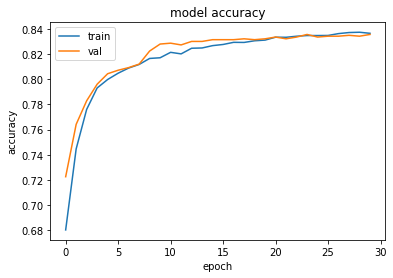

In [70]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Классификация на предобученных эмбеддингах показала наилучший результат (accuracy = 0.83). Скорее всего, нашего датасета wiki действительно оказалось недостаточно для создания хорошей эмбеддинговой модели. Также могла повлиять и разметка корпуса: в случае с предобученной моделью сохраняется информация о части речи, что тоже может влиять на результат.